Image shows: b'non-cat'


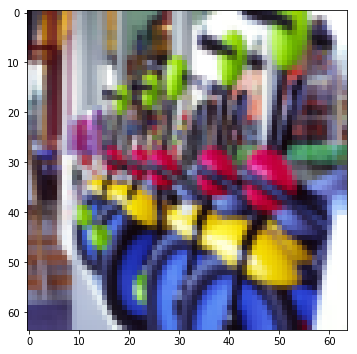

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
Train prediction accuracy: 99.04306220095694 %
Test prediction accuracy: 70.0 %
Example of wrong prediction - Image is predicted as cat. It is classified as non-cat


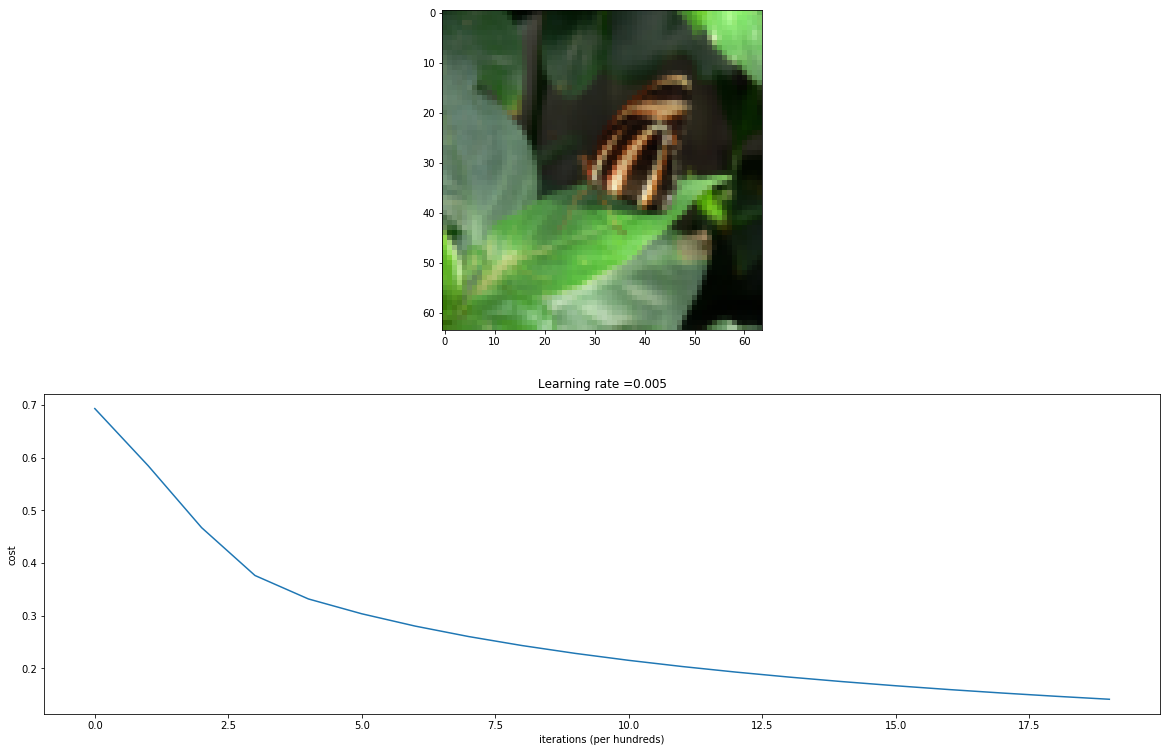

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

def load_dataset():
    f=h5py.File("train_catvnoncat.h5","r")
    train_classes=f["list_classes"][:]
    train_set_x=f["train_set_x"][:]
    train_set_y=f["train_set_y"][:]
    
    f2=h5py.File("test_catvnoncat.h5","r")
    test_classes=f2["list_classes"][:]
    test_set_x=f2["test_set_x"][:]
    test_set_y=f2["test_set_y"][:]
    
    train_set_y=train_set_y.reshape((1,train_set_y.shape[0]))
    test_set_y=test_set_y.reshape((1,test_set_y.shape[0]))
    return f,f2,train_classes,train_set_x,train_set_y,test_classes,test_set_x,test_set_y

#load data
f,f2,train_classes,train_set_x_orig,train_set_y_orig,test_classes,test_set_x_orig,test_set_y_orig=load_dataset()

#show image
print("Image shows: " + str(train_classes[np.squeeze(train_set_y_orig[:,70])]))
plt.rcParams['figure.figsize']=[20,20]
plt.subplot(311)
plt.imshow(train_set_x_orig[70])
plt.show()

#get num of train and test examples
m_train=train_set_x_orig.shape[0]
m_test=test_set_x_orig.shape[0]
num_px=train_set_x_orig.shape[1]

#reshape (209, 64, 64, 3) -> (12288, 209)
train_set_x_flatten=train_set_x_orig.reshape((train_set_x_orig.shape[0],-1)).T
test_set_x_flatten=test_set_x_orig.reshape((test_set_x_orig.shape[0],-1)).T

#standardizing datasets
train_set_x=np.divide(train_set_x_flatten,255)
test_set_x=np.divide(test_set_x_flatten,255)

def sigmoid(Z):
    A=1/(1+np.exp(-Z))
    return A

def initialize_with_zeros(dim):
    w=np.zeros((dim,1))
    b=0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return w,b

def propagate(w, b, X, Y):
    m=X.shape[1]
    
    #forward
    Z=np.dot(w.T,X)+b
    A=sigmoid(Z)

    #backward
    dZ=A-Y
    dw=np.dot(X,dZ.T)/m
    db=np.sum(dZ)/m
    
    cost=-np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1,keepdims=True)/m
    cose=np.squeeze(cost)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads={"dw":dw,
           "db":db}
    return grads,cost

def optimize(w,b,X,Y,num_iterations,learning_rate,print_cost=False):
    costs=[]
    
    for i in range(num_iterations):
        grads,cost=propagate(w,b,X,Y)
        
        if i%100==0:
            costs.append(cost)
            if(print_cost):
                print("Cost after iteration %i: %f"%(i,cost))
        
        dw = grads["dw"]
        db = grads["db"]
        
        w=w-learning_rate*dw
        b=b-learning_rate*db
        
    params={"w":w,
            "b":b}
    grads={"dw":dw,
           "db":db}
    return params,grads,costs
      
def predict(w,b,X):
    m=X.shape[1]
    A=sigmoid(np.dot(w.T,X)+b)
    Y_predict=np.zeros((1,m))
    Y_predict=np.where(A>0.5,1,0)
    return Y_predict

def model(train_set_x,train_set_y,test_set_x,test_set_y,num_iterations=2000,learning_rate=0.5,print_cost=False):
    dim=train_set_x.shape[0]
    w,b=initialize_with_zeros(dim)
    params,grads,costs=optimize(w,b,train_set_x,train_set_y,num_iterations,learning_rate,print_cost)
    w=params["w"]
    b=params["b"]
    
    Y_predict_train=predict(w,b,train_set_x)
    Y_predict_test=predict(w,b,test_set_x)
    
    #print accuracy
    print("Train prediction accuracy: {} %".format(100-np.mean(np.abs(Y_predict_train-train_set_y))*100))
    print("Test prediction accuracy: {} %".format(100-np.mean(np.abs(Y_predict_test-test_set_y))*100))
    
    d = {"costs": costs,
     "Y_prediction_test": Y_predict_test, 
     "Y_prediction_train" : Y_predict_train, 
     "w" : w, 
     "b" : b,
     "learning_rate" : learning_rate,
     "num_iterations": num_iterations}
    return d

d=model(train_set_x,train_set_y_orig,test_set_x,test_set_y_orig,num_iterations=2000,learning_rate=0.005,print_cost=True)

print("Example of wrong prediction - Image is predicted as " + str(test_classes[d["Y_prediction_test"][0,index]].decode('utf-8')) +". It is classified as " + str(test_classes[test_set_y_orig[0,index]].decode('utf-8')))
index=5
plt.subplot(312)
plt.imshow(test_set_x[:,index].reshape(num_px,num_px,3))

plt.subplot(313)
plt.plot(np.squeeze(d['costs']))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()
